In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
import cv2
import os
from scipy import fftpack
from skimage.transform import warp
from skimage import io
from image_registration import chi2_shift
import skimage
import image_registration
import tifffile
import time
import concurrent.futures
import skimage
import image_registration
from pystackreg import StackReg
import cv2 # Import the OpenCV library
import numpy as np # Import Numpy library
import matplotlib.pyplot as plt # Import matplotlib functionality
import sys
import gc
import glob

In [2]:
skimage.__file__

'/opt/anaconda/lib/python3.9/site-packages/skimage/__init__.py'

In [39]:
def get_gradient(im) :
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad
def homography_calculator2(template,moving):
    warp_mode = cv2.MOTION_HOMOGRAPHY
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 3000,  1e-3)
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(template), get_gradient(moving),warp_matrix, warp_mode, criteria)
    print (warp_matrix)
    return warp_matrix

In [40]:
def align_channel(chanel,M):
    a = skimage.transform.SimilarityTransform(matrix=M)
    return np.ma.array(warp(chanel, a, preserve_range=True,output_shape=chanel.shape, cval=-1)) 
def homography_calculator(template,moving):
    sr = StackReg(StackReg.AFFINE)
    moving_homography = sr.register(template,moving)
    return moving_homography
def generateCoefficents():
    base_folder = "/home/humangene/share/place2/BG"
    R = (cv2.imread(base_folder+"_cR.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    G = (cv2.imread(base_folder+"_cG.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    B = (cv2.imread(base_folder+"_cB.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    coeficients = []
    ref_mean = 40000
    coeficients.append((1/np.mean(R,axis=0))*ref_mean)
    coeficients.append((1/np.mean(G,axis=0))*ref_mean)
    coeficients.append((1/np.mean(B,axis=0))*ref_mean)
    return coeficients
def normalize(channel):
    a = np.quantile(channel,0.05)
    b = np.quantile(channel,0.95)
    alpha = 255/(b-a)
    betha = -alpha * a
    return channel * alpha + betha
def noise_remove(channel,median):
    return normalize((channel - median))
def clipper(channel):
    a = np.quantile(channel,0.01)
    b = np.quantile(channel,0.99)
    return np.clip(channel,a,b)
def rescale(channel):
    return channel*(255.0/pow(2,16)) 

In [41]:
base_folder = "/home/humangene/share/place2/gimmmm/"
coefs = generateCoefficents()
BR_h = np.loadtxt("/home/humangene/share/place2/tissue11/BR_h.txt")
GR_h = np.loadtxt("/home/humangene/share/place2/tissue11/GR_h.txt")

num_lines = len(glob.glob(base_folder+"*.tif"))//3
i = num_lines//2
R = clipper(cv2.imread(base_folder+"line_"+str(i)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
G = clipper(cv2.imread(base_folder+"line_"+str(i)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
B = clipper(cv2.imread(base_folder+"line_"+str(i)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
# img =cv2.merge([
#             np.clip(rescale(R)*1.7,0,255),
#             np.clip(rescale(G)*1.64516,0,255),
#             np.clip(rescale(B)*1.6346,0,255)
#             ]).astype("uint8")
img = np.clip(
         cv2.merge([
         rescale(R*coefs[0]),
         rescale(G*coefs[1]),
         rescale(B*coefs[2])
        ]),0,255).astype("uint8")[5:-5,5:-10]  
print("start")
# BR_h = homography_calculator2(img[:,:,0],img[:,:,2])
# GR_h = homography_calculator2(img[:,:,0],img[:,:,1])
# np.savetxt(base_folder+"BR_h.txt",BR_h)
# np.savetxt(base_folder+"GR_h.txt",GR_h)



start


In [42]:
img_num = 5
R = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
G = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
B = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
img = np.clip(
     cv2.merge([
     rescale(R*coefs[0]),
     align_channel(rescale(G*coefs[1]),GR_h),
     align_channel(rescale(B*coefs[2]),BR_h)
    ]),0,255).astype("uint8")[5:-5,5:-10] 

In [30]:
tifffile.imwrite("../hghg.png",img)

In [43]:
images = {}
img_nums = list(range(num_lines))
coefs = generateCoefficents()
contrast = 1
def reading_images(img_num):
    print(img_num)
    R = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    G = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    B = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    #v1.....................................................
    # images[img_num] =cv2.merge([
    #     np.clip(rescale(clipper(R/means[0] * np.max(means[0])))*np.mean(coefs[0])*contrast*1.44,0,255),
    #     align_channel(np.clip(rescale(clipper(G/means[1] * np.max(means[1])))*np.mean(coefs[1])*contrast*1.49,0,255),GR_h),
    #     align_channel(np.clip(rescale(clipper(B/means[2] * np.max(means[2])))*np.mean(coefs[2])*contrast*1.4,0,255),BR_h)
    # ]).astype("uint8")[5:-5,5:-10]
    #v2...........................................................................
    # R = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    # G = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    # B = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    # R_e = rescale(R*coefs[0])
    # G_e = align_channel(rescale(G*coefs[1]),GR_h)
    # B_e = align_channel(rescale(B*coefs[2]),BR_h)
    # images[img_num] =np.clip(
    #      cv2.merge([
    #      (R_e/np.mean(R_e,axis=0))*np.mean(R_e),
    #      (G_e/np.mean(G_e,axis=0))*np.mean(G_e),
    #      (B_e/np.mean(B_e,axis=0))*np.mean(B_e)
    #     ]),0,255).astype("uint8")[5:-5,5:-10]
    #v3.............................................................................
    images[img_num] =np.clip(
         cv2.merge([
         rescale(R*coefs[0]),
         align_channel(rescale(G*coefs[1]),GR_h),
         align_channel(rescale(B*coefs[2]),BR_h)
        ]),0,255).astype("uint8")[5:-5,5:-10]   
     
    del(R)
    del(G)
    del(B)
    del(R_e)
    del(G_e)
    del(B_e)
    gc.collect()
    return img_num
t1 = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = executor.map(reading_images,img_nums)
print(concurrent.futures.as_completed(results))
t2 = time.perf_counter()
print(t2-t1)

01

2
3
4
5
6
<generator object as_completed at 0x7f8d29d6a900>
8.232928247016389


In [44]:
line_shifts = {}
img_nums = list(range(num_lines-1))
def process_image(img_num):
    print(img_num)
    right_image = images[img_num]
    left_image = images[img_num+1]
    min_row = min(right_image.shape[0],left_image.shape[0])
    min_col = min(right_image.shape[1],left_image.shape[1])
    right_image_c = right_image[:min_row,:300]
    left_image_c = left_image[:min_row,-300:]
    im1 = cv2.cvtColor(left_image_c, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(right_image_c, cv2.COLOR_BGR2GRAY)
    yoff,xoff ,yer,xer= image_registration.chi2_shift(im1,im2,0.1)
    print(yoff,xoff)
    if yoff > 30  and xoff<0:  
        line_shifts[(img_num,img_num+1)] = (int(yoff),int(-1*xoff))
t1 = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor(max_workers = 20) as executor:
    results = list(executor.map(process_image,img_nums))
concurrent.futures.as_completed(results)
t2 = time.perf_counter()
print(t2-t1)

0
1
2
3
4
5


/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

35.732421875 -16.005859375
28.873046875 -15.142578125
40.294921875 -14.580078125
34.791015625 -15.099609375
38.712890625 -16.423828125
32.080078125 -15.580078125
4.346871217945591


In [45]:
if len(line_shifts.keys())>0:  
    ysum = 0
    xsum = 0
    for key in line_shifts.keys():
        ysum+=line_shifts[key][0]
        xsum+=line_shifts[key][1]
    y_m = ysum//len(line_shifts.keys())
    x_m = xsum//len(line_shifts.keys())
    for i in range(num_lines - 1):
        if not((i,i+1) in line_shifts.keys()):
            line_shifts[(i,i+1)] = (y_m,x_m)
else:
    for i in range(num_lines - 1):
        line_shifts[(i,i+1)] = (0,0)
        

In [46]:
sum_x = 0
sum_y = 0
for key , value in line_shifts.items():
    sum_x+=value[1]
    sum_y+=value[0]

In [47]:
valid_list = []
for key , value in line_shifts.items():
    valid_list.append(key[1])
    
yoff_sum = 0
xoff_sum = 0
tempelate = images[0]
max_tot_row = tempelate.shape[0]
max_tot_col = tempelate.shape[1]
for val in line_shifts.values():
    yoff_sum+=val[0]
    xoff_sum+=val[1]
img_shape = (max_tot_row,max_tot_col,3)
mid = (int(img_shape[0]/2),int(img_shape[1]/2))
row_numbers = img_shape[0]
tot = np.zeros((row_numbers+xoff_sum,img_shape[1]*num_lines - yoff_sum,3),dtype = np.uint8)
last_row_index = tot.shape[0]
last_col_index = tot.shape[1] 
valid_range = [last_row_index,last_row_index]
for i in range(num_lines):
    indx = num_lines - i-1
    print(indx)
    if i in valid_list:
        middle_img = images[i]
        img_shape = (middle_img.shape[0],middle_img.shape[1],3)
        row_numbers = middle_img.shape[0]
        yshift,xshift = line_shifts[(i - 1,i)]
        tot[last_row_index-row_numbers - xshift:last_row_index-xshift,last_col_index-img_shape[1]+yshift:last_col_index+yshift,:] = middle_img
        valid_range[0] = last_row_index-row_numbers
        valid_range[1] = last_row_index+xshift
        last_row_index = last_row_index-xshift
        last_col_index = last_col_index-img_shape[1]+yshift
    else:
        middle_img = images[i]
        tot[last_row_index-middle_img.shape[0]:last_row_index,last_col_index-middle_img.shape[1]:last_col_index,:] = middle_img
        valid_range[0] = last_row_index-middle_img.shape[0]
        valid_range[1] = last_row_index
        
        last_row_index = last_row_index
        last_col_index = last_col_index - middle_img.shape[1]

6
5
4
3
2
1
0


In [48]:
tot = tot[sum_y:-sum_y]

In [49]:
# R = (tot[:,:,0]/np.mean(tot[:,:,0],axis=0))*200
# G = (tot[:,:,1]/np.mean(tot[:,:,1],axis=0))*200
# B = (tot[:,:,2]/np.mean(tot[:,:,2],axis=0))*200

In [50]:
tifffile.imwrite("/home/humangene/Desktop/place2_tisuue.tif",tot)

In [ ]:
p1 = images[11][:,:504]
line1 = images[11][:,504:508]
p2 = images[11][:,508:1015]
line2 = images[11][:,1015:1020]
p3 = images[11][:,1020:1529]
line3 =images[11][:,1530:1532]
p4 =images[11][:,1532:]
whole = images[11][:,:]

In [56]:
def smooth (array , kernel_size):
    smoothed = np.zeros((array.shape[0]))
    for i in range(array.shape[0]):
        if i == 0 :
            smoothed[i] = array[i]
        elif i<kernel_size - 1:
            smoothed[i] = np.mean(array[:i+1])
        elif i>array.shape[0] - kernel_size:
            smoothed[i] = np.mean(array[i:])
        else:
            smoothed[i] = np.mean(array[i:i+kernel_size])
    return smoothed

In [144]:
base_folder = "/home/humangene/share/NEW_IR_color/3/"
i = 1
R = cv2.imread(base_folder+"line_"+str(i)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
G = cv2.imread(base_folder+"line_"+str(i)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
B = cv2.imread(base_folder+"line_"+str(i)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10]

i = 0
R_s = cv2.imread(base_folder+"line_"+str(i)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
G_s = cv2.imread(base_folder+"line_"+str(i)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
B_s = cv2.imread(base_folder+"line_"+str(i)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10]

base_folder = "/home/humangene/share/NEW_IR_color/bg/BG"
bR = cv2.imread(base_folder+"_cR.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
bG = cv2.imread(base_folder+"_cG.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
bB = cv2.imread(base_folder+"_cB.tif",cv2.IMREAD_UNCHANGED)[:,:-10]

R = clipper(R)
G = clipper(G)
B = clipper(B)

In [136]:
div_r = np.mean(R,axis=0)
div_g = np.mean(G,axis=0)
div_b = np.mean(B,axis=0)

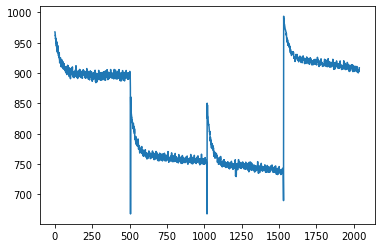

In [137]:
plt.plot(div_r)

In [177]:
coefs = generateCoefficents()
contrast = 1
R_img = rescale(R*coefs[0])
G_img = rescale(G*coefs[1])
B_img = rescale(B*coefs[2])
R_img2 = (R_img/np.mean(R_img,axis=0))*np.mean(R_img)
G_img2 = (G_img/np.mean(G_img,axis=0))*np.mean(G_img)
B_img2 = (B_img/np.mean(B_img,axis=0))*np.mean(B_img)

In [178]:
cv2.imwrite("../oo.png",cv2.merge([B_img2,G_img2,R_img2]))

True

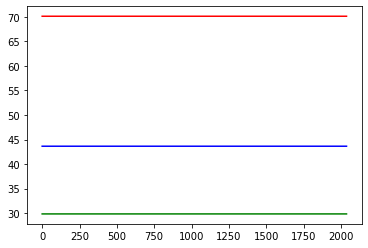

In [157]:
# R_img2 = (R_img - np.median(R_img,axis=0)) +np.max(np.median(R_img))
# G_img2 = (G_img - np.median(G_img,axis=0)) +np.max(np.median(G_img))
# B_img2 = (B_img - np.median(B_img,axis=0)) +np.max(np.median(B_img))
show_col_dis(R_img2,G_img2,B_img2)

In [154]:
cv2.imwrite("../llkk.png",cv2.merge([B_img2,G_img2,R_img2]))

True

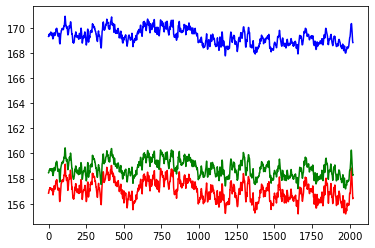

In [110]:
show_col_dis(img_test[:,:,0],img_test[:,:,1],img_test[:,:,2])

In [120]:
R = images[1][:,:,0]
G = images[1][:,:,1]
B = images[1][:,:,2]

In [121]:
def show_col_dis(R,G,B):
    plt.plot(np.mean(R,axis=0),color = "red")
    plt.plot(np.mean(G,axis=0),color = "green")
    plt.plot(np.mean(B,axis=0),color = "blue")


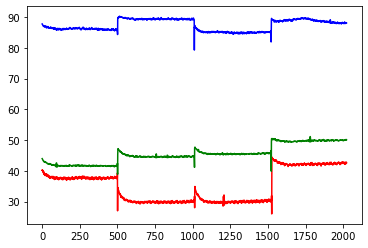

In [122]:
show_col_dis(images[0][:,:,0],images[0][:,:,1],images[0][:,:,2])

In [308]:
tifffile.imwrite("../llllll.png",img.astype("uint8"))

In [44]:
cv2.imwrite("../llllkkkkkkk.png",cv2.merge([b_trans,g_trans,r_trans]))

True

In [35]:
rgb_fft.shape[0]/2

14592.0

TypeError: Image data of dtype complex128 cannot be converted to float

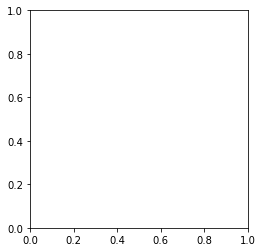

In [27]:
plt.imshow(rgb_fft)